In [6]:
import yoda
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['text.usetex'] = True
import numba as nb

In [7]:
def return_data_hist_yoda(hist_name='d01-x01-y01'):
    # print('data hist name = ', hist_name)
    data_hist_path = os.path.join(os.getcwd(), 'rivet_histograms', 'data', 'ALEPH_1996_S3486095.yoda')
    tree_name_data='/REF/ALEPH_1996_S3486095'
    yoda_file = yoda.read(data_hist_path)
    full_hist_name = '%s/%s' % (tree_name_data, hist_name)
    yoda_hist = yoda_file[full_hist_name]
    hist_edges = yoda_hist.xVals()
    hist_values = yoda_hist.yVals()
    hist_errs = yoda_hist.yErrs()[:,0]
    return hist_edges, hist_values, hist_errs

In [8]:
def return_simulation_hist_yoda(filename = 'ALEPH_1996_S3486095_card_0.yoda', hist_name='d01-x01-y01'):
    # print('simulation hist name = ', hist_name)
    simulation_hist_path = os.path.join(os.getcwd(), 'rivet_histograms', 'simulation', filename)
    yoda_file = yoda.read(simulation_hist_path)
    tree_name_simulation='/ALEPH_1996_S3486095'
    
    full_hist_name = '%s/%s' % (tree_name_simulation, hist_name)
    yoda_hist = yoda_file[full_hist_name]
    hist_edges = yoda_hist.xVals()
    hist_values = yoda_hist.yVals()
    hist_errs = yoda_hist.yErrs()
    return hist_edges, hist_values, hist_errs

In [12]:
def get_hist_names():
    hist_names=[]
    for i in range(1,43):
        hist_names.append('d{:02d}-x01-y01'.format(i) )
        #13-16 and 24 not present in yoda files
    hist_names.remove('d13-x01-y01')
    hist_names.remove('d14-x01-y01')
    hist_names.remove('d15-x01-y01')
    hist_names.remove('d16-x01-y01')
    hist_names.remove('d24-x01-y01')
    # d25-x01-y01 gives error of unequal lengths
    # hist_names.remove('d25-x01-y01')
    # hist_names.remove('d26-x01-y01')
    # hist_names.remove('d27-x01-y01')
    #19-23 are empty
    hist_names.remove('d19-x01-y01')
    hist_names.remove('d20-x01-y01')
    hist_names.remove('d21-x01-y01')
    hist_names.remove('d22-x01-y01')
    hist_names.remove('d23-x01-y01')
    #36 gives a huge chi2 (=10^18) for unknown reason
    hist_names.remove('d36-x01-y01')
    # 41
    hist_names.remove('d41-x01-y01')
    hist_names.remove('d42-x01-y01')

    return hist_names

In [37]:
@nb.njit(parallel=True,fastmath=True)
def chi2(data_hist, data_errs, sim_hist, sim_errs, print_=True):
    assert len(data_hist) == len(sim_hist)
    select = sim_hist > 0.0
    hsim = sim_hist[select]
    hdat = data_hist[select]
    sim_errs = sim_errs[select]
    data_errs = data_errs[select]
    
    
    num = (hdat - hsim)**2
    den = np.sqrt(hsim + sim_errs**2 + data_errs**2) 
    den = np.where(den >0, den, 1)
    
    chi_2 =(num/den).sum()
    chi_2_per_dof =chi_2/len(hdat) 


    chi2 = np.sqrt(chi_2_per_dof)

    
    if print_==True:
        print('scaled chi2 per dof = \t', chi2)
    return chi2


## we need 3 test statistics
1. $\lambda_{\text{Observed, pred}}$ is between the actually observed (fixed) data and the prediction at $\theta_i$ 

$$ \lambda_{\text{Observed, pred}}(D;\theta_i)=\sum_{\mathcal{O}} \sqrt{ \frac{1}{|b|} \sum_{b \in \mathcal{O}}\left(\frac{\text{MC}_{(b)}\left(\theta_i\right)-\text{Data}_{(b)}}{\Delta_b}\right)^2}$$

where $\text{MC}_{(b)}\left(\theta_i\right)$ denotes the MC prediction for observable $\mathcal{O}$ at bin $b$, which depends on the parameters $\theta_i = \{ a_i, b_i \}$, and $\Delta_{\text{MC}, \ b}$ represents the error in the MC prediction in the bin $b$, and $|b|$ represents the number of bins in observable $\mathcal{O}$'s histogram. $\Delta_b = \sqrt{\Delta_{\text{Data}, \ b}^2 + \Delta_{\text{MC}, \ b}^2}$

2. $\lambda_{\text{simulated-observed, pred}}$ is between the prediction at $\theta_i$ and the prediction at a shuffled point $\theta^*$

$$ \lambda_{\text{simulated-observed, pred}}(\mathcal{D};\theta_i) =\sum_{\mathcal{O}} \sqrt{ \frac{1}{|b|} \sum_{b \in \mathcal{O}}\left(\frac{\text{MC}_{(b)}\left(\theta_i\right)-\text{MC}_{(b)}\left(\theta_i^*\right)}{\Delta_b}\right)^2}$$

where $\text{MC}_{(b)}\left(\theta_i^*\right)$ is the MC prediction at a shuffled parameter point $\theta^*$.

3. $\lambda_{\text{simulated, pred}}(\mathcal{D};\theta_i)$

$$ \lambda_{\text{simulated, pred}}(\mathcal{D};\theta_i)=\sum_{\mathcal{O}} \sqrt{ \frac{1}{|b|} \sum_{b \in \mathcal{O}}\left(\frac{\text{MC}_{(b)}\left(\theta_i\right)-\text{SimulatedData}_{(b)} (\theta_i)}{\Delta_b}\right)^2}$$

And need $Z_{1,3}$ (and $Z_{2,3}$ for ML modelling)

$$Z_{1,3} = \mathbb{1} \left[ \lambda_{\text{simulated, pred}}(\mathcal{D};\theta_i) \le \lambda_{\text{Observed, pred}}(D;\theta_i) \right] $$

$$Z_{2,3} = \mathbb{1} \left[ \lambda_{\text{simulated, pred}}(\mathcal{D};\theta_i) \le \lambda_{\text{simulated-observed, pred}}(\mathcal{D};\theta_i) \right] $$




In [38]:
def overall_chi2_observed_pred(sim_yoda_file='ALEPH_1996_S3486095_card_0.yoda', print_=True):
    """ returns the chi2 between the actually observed data and the predicted simulation"""

    hist_names = get_hist_names()
    overall_chi2 = 0
    for hist_name in hist_names:
        data_hist_edges, data_hist, data_hist_errs = return_data_hist_yoda(hist_name=hist_name)
        simulation_hist_edges, simulation_hist, simulation_hist_errs = return_simulation_hist_yoda(filename =sim_yoda_file , hist_name=hist_name)
        chi2_ = chi2(data_hist, data_hist_errs, simulation_hist, simulation_hist_errs, print_=print_)
        overall_chi2 = overall_chi2 +chi2_

    if print_==True:
        print('overall chi2= ', overall_chi2)
    return overall_chi2

In [26]:
def overall_chi2_shuffledpred_pred(sim_yoda_file='ALEPH_1996_S3486095_card_0.yoda', shuffled_sim_yoda_file = 'ALEPH_1996_S3486095_card_1.yoda',print_=True):
    """ returns the chi2 between the simulated pre"""

    hist_names = get_hist_names()
    overall_chi2 = 0
    for hist_name in hist_names:
        data_hist_edges, data_hist, data_hist_errs = return_simulation_hist_yoda(filename =shuffled_sim_yoda_file , hist_name=hist_name)
        simulation_hist_edges, simulation_hist, simulation_hist_errs = return_simulation_hist_yoda(filename =sim_yoda_file , hist_name=hist_name)
        
        chi2_ = chi2(data_hist, data_hist_errs, simulation_hist, simulation_hist_errs, print_=print_)
        overall_chi2 = overall_chi2 +chi2_

    if print_==True:
        print('overall chi2= ', overall_chi2)
    return overall_chi2

In [28]:
def extract_numbers(s):
    import re
    
    return [int(x) if x.isdigit() else x for x in re.split('([0-9]+)', s)]

In [29]:
df = pd.read_csv(os.path.join(os.getcwd(), 'a_b_samples_uniform_1.csv'))[['a','b']]
df.head()

,a,b
0,0.890731,1.773921
1,1.306220,1.490305
2,1.653587,0.538929
3,0.666805,1.375998
4,1.105232,1.243956


In [30]:
def add_overall_observed_chi2(df):
    sim_files = os.listdir(os.path.join(os.getcwd(), 'rivet_histograms', 'simulation') )
    sorted_list_files = sorted(sim_files, key = extract_numbers)
    for rowind, row in df.iterrows():
        df.loc[rowind, 'lambda_observed_pred'] = overall_chi2_observed_pred(sim_yoda_file = sorted_list_files[rowind], print_=False)

    return df

In [31]:
df= add_overall_observed_chi2(df)
df.head()

,a,b,lambda_observed_pred
0,0.890731,1.773921,32.975294
1,1.306220,1.490305,14.108912
2,1.653587,0.538929,51.926591
3,0.666805,1.375998,22.212304
4,1.105232,1.243956,13.462781


In [40]:
def add_shuffled_overall_chi2(df,subsample=10):
    import random
    sim_files = os.listdir(os.path.join(os.getcwd(), 'rivet_histograms', 'simulation') )
    sorted_list_files = sorted(sim_files, key = extract_numbers)
    shuffled_list_files = sorted_list_files[:]
    random.shuffle(shuffled_list_files)
    for rowind, row in df.iterrows():
        df.loc[rowind, 'lambda_simulatedobserved_pred'] = overall_chi2_shuffledpred_pred(sim_yoda_file= sorted_list_files[rowind], 
                                                                                         shuffled_sim_yoda_file = shuffled_list_files[rowind],
                                                                                         print_=False)

    return df

In [39]:
df =add_shuffled_overall_chi2(df)
df.head()

,a,b,lambda_observed_pred,lambda_simulatedobserved_pred
0,0.890731,1.773921,32.975294,64.563921
1,1.306220,1.490305,14.108912,17.449024
2,1.653587,0.538929,51.926591,71.843969
3,0.666805,1.375998,22.212304,6.531897
4,1.105232,1.243956,13.462781,9.503130


In [47]:
def return_newseeds_hist_yoda(filename, hist_name='d01-x01-y01'):
    # print('simulation hist name = ', hist_name)
    simulation_hist_path = os.path.join(os.getcwd(), 'rivet_histograms', 'newseeds', filename)
    yoda_file = yoda.read(simulation_hist_path)
    tree_name_simulation='/ALEPH_1996_S3486095'
    
    full_hist_name = '%s/%s' % (tree_name_simulation, hist_name)
    yoda_hist = yoda_file[full_hist_name]
    hist_edges = yoda_hist.xVals()
    hist_values = yoda_hist.yVals()
    hist_errs = yoda_hist.yErrs()
    return hist_edges, hist_values, hist_errs

In [71]:
def overall_chi2_newseeds_pred(sim_yoda_file, shuffled_sim_yoda_file,print_=True):
    """ returns the chi2 between the simulated pre"""

    hist_names = get_hist_names()
    overall_chi2 = 0
    for hist_name in hist_names:
        data_hist_edges, data_hist, data_hist_errs = return_newseeds_hist_yoda(filename =shuffled_sim_yoda_file , hist_name=hist_name)
        simulation_hist_edges, simulation_hist, simulation_hist_errs = return_simulation_hist_yoda(filename =sim_yoda_file , hist_name=hist_name)
        
        chi2_ = chi2(data_hist, data_hist_errs, simulation_hist, simulation_hist_errs, print_=print_)
        overall_chi2 = overall_chi2 +chi2_

    if print_==True:
        print('overall chi2= ', overall_chi2)
    return overall_chi2

In [72]:
def add_simulated_pred_overall_chi2(df,subsample=10):
    import random
    sim_files = os.listdir(os.path.join(os.getcwd(), 'rivet_histograms', 'simulation') )
    sorted_list_files = sorted(sim_files, key = extract_numbers)

    newseeds_files = os.listdir(os.path.join(os.getcwd(), 'rivet_histograms', 'newseeds') )
    sorted_newseeds_files = sorted(newseeds_files, key=extract_numbers)
    for rowind, row in df.iterrows():
        df.loc[rowind, 'lambda_simulated_pred'] = overall_chi2_newseeds_pred(sim_yoda_file= sorted_list_files[rowind], 
                                                                                         shuffled_sim_yoda_file = sorted_newseeds_files[rowind],
                                                                                         print_=False)

    return df

In [73]:
df =add_simulated_pred_overall_chi2(df)
df.head()

,a,b,lambda_observed_pred,lambda_simulatedobserved_pred,lambda_simulated_pred,Z_13,Z_23
0,0.890731,1.773921,32.975294,64.563921,20.020884,1.0,1.0
1,1.306220,1.490305,14.108912,17.449024,2.914733,1.0,1.0
2,1.653587,0.538929,51.926591,71.843969,3.109487,1.0,1.0
3,0.666805,1.375998,22.212304,6.531897,2.969360,1.0,1.0
4,1.105232,1.243956,13.462781,9.503130,3.246715,1.0,1.0


In [74]:
%%timeit
for rowind, row in df.iterrows():
    df.loc[rowind, 'Z_13'] = (row['lambda_simulated_pred'] <= row['lambda_observed_pred']).astype(int)
    df.loc[rowind, 'Z_23'] = (row['lambda_simulated_pred'] <= row['lambda_simulatedobserved_pred']).astype(int)

214 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
df.head()

,a,b,lambda_observed_pred,lambda_simulatedobserved_pred,lambda_simulated_pred,Z_13,Z_23
0,0.890731,1.773921,32.975294,64.563921,20.020884,1.0,1.0
1,1.306220,1.490305,14.108912,17.449024,2.914733,1.0,1.0
2,1.653587,0.538929,51.926591,71.843969,3.109487,1.0,1.0
3,0.666805,1.375998,22.212304,6.531897,2.969360,1.0,1.0
4,1.105232,1.243956,13.462781,9.503130,3.246715,1.0,1.0


In [76]:
df.describe()

,a,b,lambda_observed_pred,lambda_simulatedobserved_pred,lambda_simulated_pred,Z_13,Z_23
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000
mean,0.990061,1.093910,28.461729,35.281370,2.933156,1.0,0.989000
std,0.572408,0.513808,16.750456,27.302337,0.594405,0.0,0.104355
min,0.001196,0.200896,12.639947,0.000000,2.144709,1.0,0.000000
25%,0.511282,0.654855,15.567232,12.902236,2.741885,1.0,1.000000
50%,0.984827,1.089722,22.096023,28.467938,2.906555,1.0,1.000000
75%,1.500206,1.521528,36.399083,51.401322,3.078849,1.0,1.000000
max,1.999527,1.997974,99.777164,143.831801,20.020884,1.0,1.000000


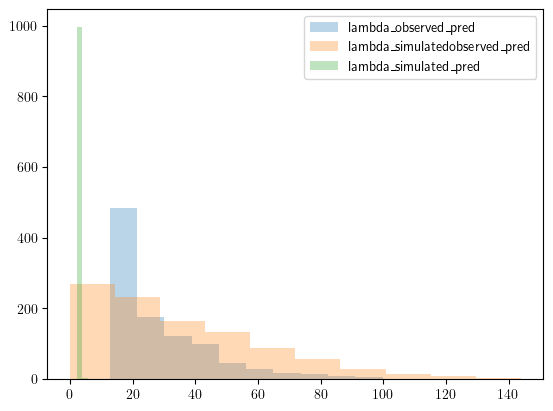

In [77]:
plt.hist(df.lambda_observed_pred, label='lambda_observed_pred', alpha=0.3)

plt.hist(df.lambda_simulatedobserved_pred, label='lambda_simulatedobserved_pred', alpha=0.3)
plt.hist(df.lambda_simulated_pred, label='lambda_simulated_pred', alpha=0.3)
plt.legend()